In [1]:
import pickle
from pathlib import Path
import os
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
OUTPUT_DIR = Path("./outputs")
output_files = os.listdir(OUTPUT_DIR)

In [3]:
model_names = {
    "gemma-3-4b-it": "Gemma 3 4B",
    "gemma-3-12b-it": "Gemma 3 12B",
    "gemma-3-27b-it": "Gemma 3 27B"
}

In [4]:
def get_dataset_metrics(dataset_name):
    dataset_files = [file for file in output_files if file.startswith(dataset_name)]
    dataset_files = sorted(dataset_files, key=lambda x: int(x.split("_")[1].split("-")[2][:-1]))
    
    dataset_metrics = {}
    for dataset_file in dataset_files:
        model_name = dataset_file.split(".")[0].split("_")[1]
        lfw_path = OUTPUT_DIR / dataset_file
        with open(lfw_path, "rb") as f:
            dataset_metrics[model_name] = pickle.load(f)
    
    return dataset_metrics

## LFW

In [13]:
lfw_df = pd.read_csv("datasets/lfw/pairs.csv")

In [14]:
lfw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        6000 non-null   object 
 1   imagenum1   6000 non-null   int64  
 2   imagenum2   6000 non-null   object 
 3   Unnamed: 3  3000 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 187.6+ KB


In [5]:
lfw_metrics = get_dataset_metrics("lfw")

In [79]:
lfw_table_data = []
for model_name, metrics in lfw_metrics.items():
    lfw_table_data.append({
        "Model": model_names[model_name],
        "EER (%)": metrics["eer"] * 100,
        "AUC": metrics["auc"],
        "Acc. @ EER (%)": metrics["accuracy_at_eer"],
        "FAR @ EER (%)": metrics["far_at_eer"],
        "FRR @ EER (%)": metrics["frr_at_eer"],
    })

In [80]:
lfw_performance = pd.DataFrame(lfw_table_data).set_index("Model")
print(lfw_performance.to_string(float_format="%.2f"))

             EER (%)  AUC  Acc. @ EER (%)  FAR @ EER (%)  FRR @ EER (%)
Model                                                                  
Gemma 3 4B      8.55 0.97           91.45           8.53           8.57
Gemma 3 12B     4.63 0.99           95.37           4.60           4.67
Gemma 3 27B     4.07 0.99           95.93           4.00           4.13


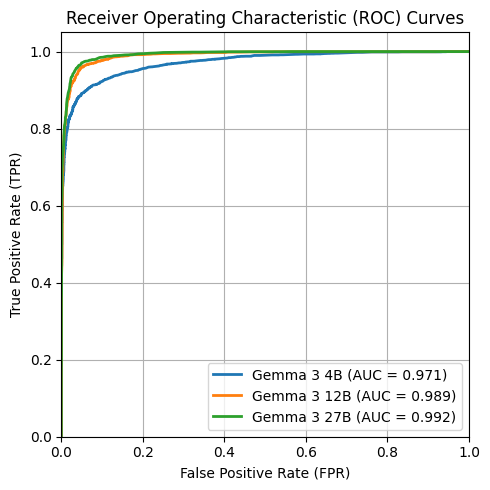

In [9]:
plt.figure(figsize=(5, 5))
for model_name, metrics in lfw_metrics.items():
    fpr = metrics["fpr"]
    tpr = metrics["tpr"]
    auc = metrics["auc"]
    plt.plot(fpr, tpr, lw=2, label=f'{model_names[model_name]} (AUC = {auc:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

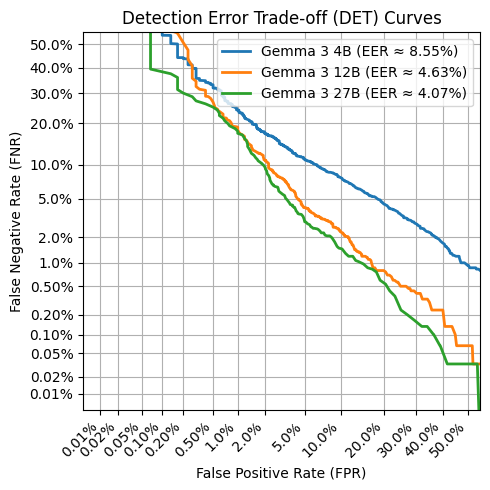

In [54]:
plt.figure(figsize=(5, 5))

# Define tick positions for DET curve (probabilities)
det_ticks_prob = np.array([0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5])
det_ticks_nd = norm.ppf(det_ticks_prob) # Convert to Normal Deviate Scale (Z-score)
det_tick_labels = [f"{p*100:.2f}%" if p < 0.01 else f"{p*100:.1f}%" for p in det_ticks_prob]

for model_name, metrics in lfw_metrics.items():
    fpr = metrics["fpr"]
    tpr = metrics["tpr"]
    fnr = 1 - tpr

    # Filter out 0s and 1s before ppf, as norm.ppf(0) = -inf, norm.ppf(1) = inf
    # Add a small epsilon to avoid issues with exact 0 or 1
    epsilon = 1e-7
    fpr_clipped = np.clip(fpr, epsilon, 1 - epsilon)
    fnr_clipped = np.clip(fnr, epsilon, 1 - epsilon)
    
    fpr_nd = norm.ppf(fpr_clipped)
    fnr_nd = norm.ppf(fnr_clipped)
    
    plt.plot(fpr_nd, fnr_nd, lw=2, label=f'{model_names[model_name]} (EER ≈ {metrics.get("eer", np.nan)*100:.2f}%)')

plt.xticks(det_ticks_nd, det_tick_labels, rotation=45, ha="right")
plt.yticks(det_ticks_nd, det_tick_labels)
min_val = norm.ppf(0.00005) # Smallest value for axis limit
max_val = norm.ppf(0.55)   # Largest value for axis limit (50% is mid-point)
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Negative Rate (FNR)')
plt.title('Detection Error Trade-off (DET) Curves')
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

## AgeDB - Age

In [ ]:
agedb_df = pd.read_csv()

In [81]:
agedb_age_metrics = get_dataset_metrics("agedb-age")

In [82]:
age_table_data = []
for model_name, age_metrics in agedb_age_metrics.items():
    row = {
        "Model": model_names[model_name],
        "MAE (Years)": age_metrics.get("mae", np.nan),
        "Error Std. Dev.": age_metrics.get("error_std", np.nan),
    }
    for cs_key, cs_value in age_metrics["cs_scores"].items():
        # Reformat key for display e.g. "CS@1yrs" -> "CS@1yr (%)"
        display_key = cs_key.replace("yrs", "yr") + " (%)"
        row[display_key] = cs_value
    age_table_data.append(row)

In [83]:
agedb_age_performance = pd.DataFrame(age_table_data).set_index("Model")
print(agedb_age_performance.to_string(float_format="%.2f"))

             MAE (Years)  Error Std. Dev.  CS@1yr (%)  CS@3yr (%)  CS@5yr (%)  CS@7yr (%)  CS@10yr (%)
Model                                                                                                 
Gemma 3 4B         21.36            17.03        4.43       10.46       16.19       21.80        30.12
Gemma 3 12B        13.02            12.19        7.69       17.32       26.58       35.36        47.65
Gemma 3 27B        19.24            21.69        5.40       12.95       19.32       25.81        35.21


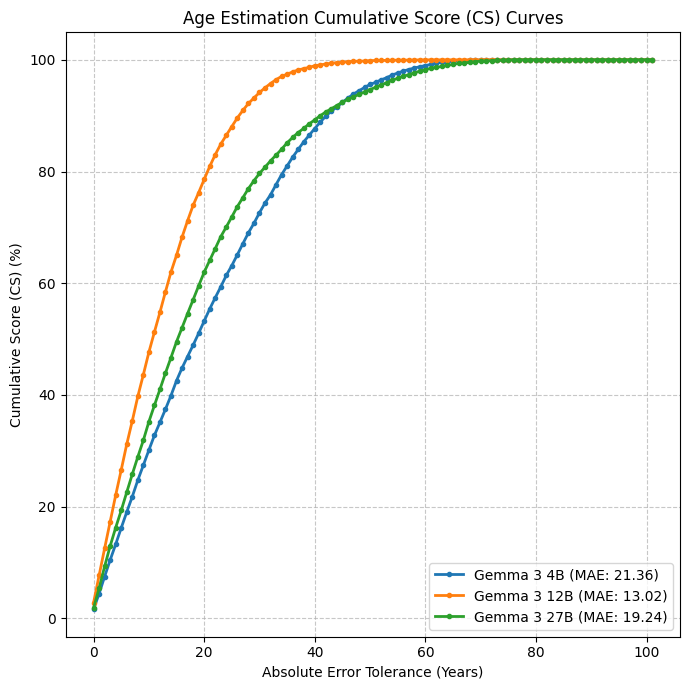

In [ ]:
plt.figure(figsize=(7, 7))
max_error_tolerance_plot = 101 # Max error tolerance to plot on x-axis
error_tolerances = np.arange(0, max_error_tolerance_plot + 1)

for model_name, age_metrics in agedb_age_metrics.items():
    raw_errors = np.abs(np.array(age_metrics["errors"]))

    cs_curve_values = []
    for tol in error_tolerances:
        cs_curve_values.append(np.mean(raw_errors <= tol) * 100)
    plt.plot(error_tolerances, cs_curve_values, marker='.', linestyle='-', lw=2, label=f'{model_names[model_name]} (MAE: {age_metrics.get("mae", 0):.2f})')
    
plt.xlabel('Absolute Error Tolerance (Years)')
plt.ylabel('Cumulative Score (CS) (%)')
plt.title('Age Estimation Cumulative Score (CS) Curves')
plt.yticks(np.arange(0, max_error_tolerance_plot, 10))
plt.yticks(np.arange(0, 101, 20))
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## AgeDB - Gender

In [84]:
agedb_gender_metrics = get_dataset_metrics("agedb-gender")

In [85]:
gender_table_data = []
gender_classes = ["female", "male"]
for model_name, gender_metrics in agedb_gender_metrics.items():
    row = {
        "Model": model_names[model_name],
        "Accuracy (%)": gender_metrics["accuracy"]
    }
    confusion_matrics = gender_metrics["confusion_matrix"]
    y_true = [0] * sum(confusion_matrics[0]) + [1] * sum(confusion_matrics[1])
    y_pred = [0] * confusion_matrics[0][0] + [1] * confusion_matrics[0][1] + [0] * confusion_matrics[1][0] + [1] * confusion_matrics[1][1]
    
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    for i, cls_name in enumerate(gender_classes):
        row[f"F1 ({cls_name.capitalize()})"] = f1[i]
        row[f"Prec ({cls_name.capitalize()})"] = precision[i]
        row[f"Rec ({cls_name.capitalize()})"] = recall[i]
    gender_table_data.append(row)

In [86]:
agedb_gender_performance = pd.DataFrame(gender_table_data).set_index("Model")
print(agedb_gender_performance.to_string(float_format="%.2f"))

             Accuracy (%)  F1 (Female)  Prec (Female)  Rec (Female)  F1 (Male)  Prec (Male)  Rec (Male)
Model                                                                                                  
Gemma 3 4B          97.99         0.98           0.97          0.98       0.98         0.99        0.98
Gemma 3 12B         97.64         0.97           0.97          0.97       0.98         0.98        0.98
Gemma 3 27B         98.00         0.98           0.97          0.98       0.98         0.99        0.98


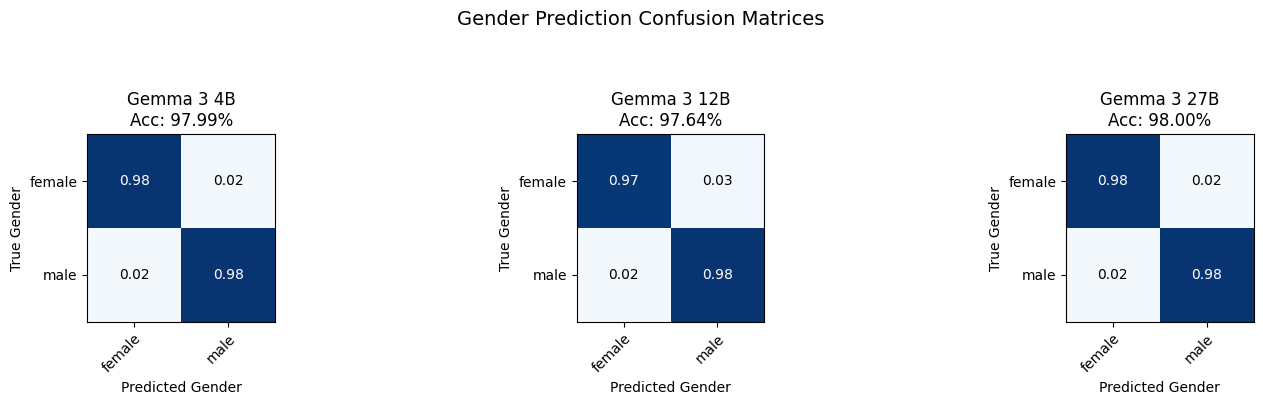

In [41]:
num_models = len(agedb_gender_metrics)
cols = min(3, num_models)
rows = (num_models + cols - 1) // cols
fig_cm, axes_cm = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)
axes_cm_flat = axes_cm.flatten()

model_idx = 0
for model_name, gender_metrics in agedb_gender_metrics.items():
    ax = axes_cm_flat[model_idx]
    cm_raw = np.array(gender_metrics["confusion_matrix"])

    cm_normalized = cm_raw.astype('float') / cm_raw.sum(axis=1, keepdims=True)
    cm_normalized = np.nan_to_num(cm_normalized)

    ax.imshow(cm_normalized, cmap="Blues", vmin=0, vmax=1)
    ax.set_xticks(range(len(gender_classes)), labels=gender_classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(range(len(gender_classes)), labels=gender_classes)
    ax.set_title(f'{model_names[model_name]}\nAcc: {gender_metrics.get("accuracy", 0):.2f}%')
    ax.set_xlabel('Predicted Gender')
    ax.set_ylabel('True Gender')
    
    for i in range(len(gender_classes)):
        for j in range(len(gender_classes)):
            text = ax.text(j, i, f"{cm_normalized[i, j]:.2f}", ha='center', va='center', color='black' if cm_normalized[i, j] < 0.5 else 'white')
    
    model_idx += 1

fig_cm.suptitle('Gender Prediction Confusion Matrices', fontsize=14, y=1.03 if rows > 1 else 1.0)
plt.tight_layout(rect=[0, 0, 1, 0.96 if rows > 1 else 0.92]) # Adjust rect to make space for suptitle
plt.show()

## CASIA

In [87]:
casia_metrics = get_dataset_metrics("casia-iris")

In [88]:
casia_table_data = []
for model_name, metrics in casia_metrics.items():
    casia_table_data.append({
        "Model": model_names[model_name],
        "EER (%)": metrics["eer"] * 100,
        "AUC": metrics["auc"],
        "Acc. @ EER (%)": metrics["accuracy_at_eer"],
        "FAR @ EER (%)": metrics["far_at_eer"],
        "FRR @ EER (%)": metrics["frr_at_eer"],
    })

In [89]:
casia_performance = pd.DataFrame(casia_table_data).set_index("Model")
print(casia_performance.to_string(float_format="%.2f"))

             EER (%)  AUC  Acc. @ EER (%)  FAR @ EER (%)  FRR @ EER (%)
Model                                                                  
Gemma 3 4B     35.05 0.70           64.94          35.00          35.11
Gemma 3 12B    33.28 0.73           66.72          33.24          33.33
Gemma 3 27B    29.94 0.76           70.06          30.15          29.73


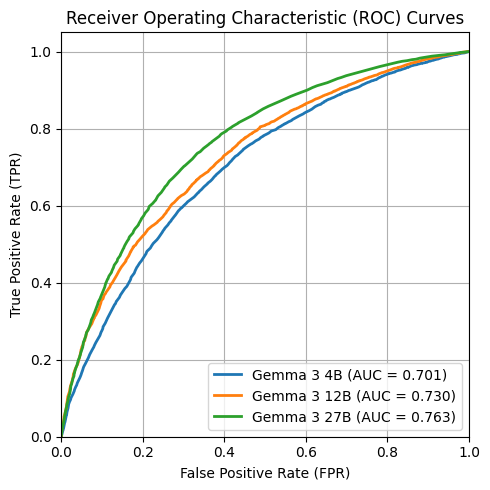

In [46]:
plt.figure(figsize=(5, 5))
for model_name, metrics in casia_metrics.items():
    fpr = metrics["fpr"]
    tpr = metrics["tpr"]
    auc = metrics["auc"]
    plt.plot(fpr, tpr, lw=2, label=f'{model_names[model_name]} (AUC = {auc:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

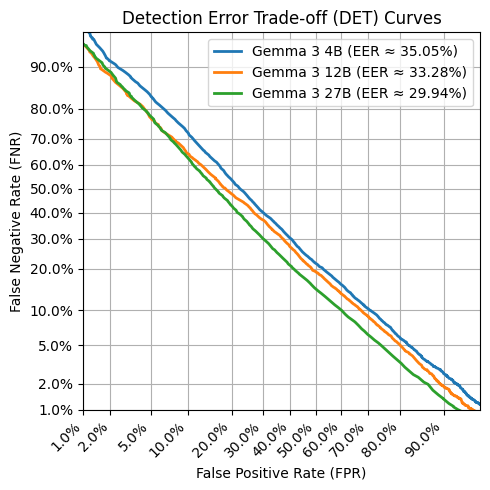

In [53]:
plt.figure(figsize=(5, 5))

# Define tick positions for DET curve (probabilities)
det_ticks_prob = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
det_ticks_nd = norm.ppf(det_ticks_prob) # Convert to Normal Deviate Scale (Z-score)
det_tick_labels = [f"{p*100:.2f}%" if p < 0.01 else f"{p*100:.1f}%" for p in det_ticks_prob]

for model_name, metrics in casia_metrics.items():
    fpr = metrics["fpr"]
    tpr = metrics["tpr"]
    fnr = 1 - tpr

    # Filter out 0s and 1s before ppf, as norm.ppf(0) = -inf, norm.ppf(1) = inf
    # Add a small epsilon to avoid issues with exact 0 or 1
    epsilon = 1e-7
    fpr_clipped = np.clip(fpr, epsilon, 1 - epsilon)
    fnr_clipped = np.clip(fnr, epsilon, 1 - epsilon)
    
    fpr_nd = norm.ppf(fpr_clipped)
    fnr_nd = norm.ppf(fnr_clipped)
    
    plt.plot(fpr_nd, fnr_nd, lw=2, label=f'{model_names[model_name]} (EER ≈ {metrics.get("eer", np.nan)*100:.2f}%)')

plt.xticks(det_ticks_nd, det_tick_labels, rotation=45, ha="right")
plt.yticks(det_ticks_nd, det_tick_labels)
min_val = norm.ppf(0.01) # Smallest value for axis limit
max_val = norm.ppf(0.95)   # Largest value for axis limit (50% is mid-point)
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Negative Rate (FNR)')
plt.title('Detection Error Trade-off (DET) Curves')
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

## FVC

In [67]:
fvc_metrics = get_dataset_metrics("fvc")

In [74]:
fvc_table_data = []
for model_name, model_metrics in fvc_metrics.items():
    model_data = {
        "Model": model_names[model_name],
    }
    for year, year_metrics in model_metrics.items():
        dbs_metrics = year_metrics.get("Dbs", {})
        for db_name, db_metrics in dbs_metrics.items():
            model_data[f"{year} {db_name} EER (%)"] = db_metrics["eer"] * 100
            model_data[f"{year} {db_name} AUC"] = db_metrics["auc"]
            model_data[f"{year} {db_name} Acc. @ EER (%)"] = db_metrics["accuracy_at_eer"]
            model_data[f"{year} {db_name} FAR @ EER (%)"] = db_metrics["far_at_eer"]
            model_data[f"{year} {db_name} FRR @ EER (%)"] = db_metrics["frr_at_eer"]
        average_metrics = year_metrics.get("Average", {})
        model_data[f"{year} Average EER (%)"] = average_metrics["eer"] * 100
        model_data[f"{year} Average AUC"] = average_metrics["auc"]
        model_data[f"{year} Average Acc. @ EER (%)"] = average_metrics["accuracy_at_eer"]
        model_data[f"{year} Average FAR @ EER (%)"] = average_metrics["far_at_eer"]
        model_data[f"{year} Average FRR @ EER (%)"] = average_metrics["frr_at_eer"]
    fvc_table_data.append(model_data)

In [77]:
fvc_performance = pd.DataFrame(fvc_table_data).set_index("Model")
print(fvc_performance.to_string(float_format="%.2f"))

             FVC2000 Db1_ EER (%)  FVC2000 Db1_ AUC  FVC2000 Db1_ Acc. @ EER (%)  FVC2000 Db1_ FAR @ EER (%)  FVC2000 Db1_ FRR @ EER (%)  FVC2000 Db2_ EER (%)  FVC2000 Db2_ AUC  FVC2000 Db2_ Acc. @ EER (%)  FVC2000 Db2_ FAR @ EER (%)  FVC2000 Db2_ FRR @ EER (%)  FVC2000 Db3_ EER (%)  FVC2000 Db3_ AUC  FVC2000 Db3_ Acc. @ EER (%)  FVC2000 Db3_ FAR @ EER (%)  FVC2000 Db3_ FRR @ EER (%)  FVC2000 Db4_ EER (%)  FVC2000 Db4_ AUC  FVC2000 Db4_ Acc. @ EER (%)  FVC2000 Db4_ FAR @ EER (%)  FVC2000 Db4_ FRR @ EER (%)  FVC2000 Average EER (%)  FVC2000 Average AUC  FVC2000 Average Acc. @ EER (%)  FVC2000 Average FAR @ EER (%)  FVC2000 Average FRR @ EER (%)  FVC2002 Db1_ EER (%)  FVC2002 Db1_ AUC  FVC2002 Db1_ Acc. @ EER (%)  FVC2002 Db1_ FAR @ EER (%)  FVC2002 Db1_ FRR @ EER (%)  FVC2002 Db2_ EER (%)  FVC2002 Db2_ AUC  FVC2002 Db2_ Acc. @ EER (%)  FVC2002 Db2_ FAR @ EER (%)  FVC2002 Db2_ FRR @ EER (%)  FVC2002 Db3_ EER (%)  FVC2002 Db3_ AUC  FVC2002 Db3_ Acc. @ EER (%)  FVC2002 Db3_ FAR @ EER (%)  

In [99]:
average_columns = [col for col in fvc_performance.columns if "Average" in col and "Acc." in col]
print(fvc_performance[average_columns].to_string(float_format="%.2f"))

             FVC2000 Average Acc. @ EER (%)  FVC2002 Average Acc. @ EER (%)  FVC2004 Average Acc. @ EER (%)
Model                                                                                                      
Gemma 3 4B                            32.00                           36.57                           37.16
Gemma 3 12B                           34.90                           41.41                           42.56
Gemma 3 27B                           30.07                           38.23                           39.80


## CelebA

In [90]:
celeba_metrics = get_dataset_metrics("celeba")

In [95]:
celeba_table_data = []
for model_name, model_metrics in celeba_metrics.items():
    model_data = {
        "Model": model_names[model_name],
    }
    for attribute_name, attribute_metrics in model_metrics.items():
        if attribute_name == "overall":
            continue
        model_data[f"{attribute_name} EER (%)"] = attribute_metrics["eer"] * 100
        model_data[f"{attribute_name} AUC"] = attribute_metrics["auc"]
        model_data[f"{attribute_name} Acc. @ EER (%)"] = attribute_metrics["accuracy_at_eer"]
        model_data[f"{attribute_name} FAR @ EER (%)"] = attribute_metrics["far_at_eer"]
        model_data[f"{attribute_name} FRR @ EER (%)"] = attribute_metrics["frr_at_eer"]
    model_data["Average EER (%)"] = model_metrics["overall"]["eer"] * 100
    model_data["Average AUC"] = model_metrics["overall"]["auc"]
    model_data["Average Acc. @ EER (%)"] = model_metrics["overall"]["accuracy_at_eer"]
    model_data["Average FAR @ EER (%)"] = model_metrics["overall"]["far_at_eer"]
    model_data["Average FRR @ EER (%)"] = model_metrics["overall"]["frr_at_eer"]
    celeba_table_data.append(model_data)

In [96]:
celeba_performance = pd.DataFrame(celeba_table_data).set_index("Model")
print(celeba_performance.to_string(float_format="%.2f"))

             5_o_Clock_Shadow EER (%)  5_o_Clock_Shadow AUC  5_o_Clock_Shadow Acc. @ EER (%)  5_o_Clock_Shadow FAR @ EER (%)  5_o_Clock_Shadow FRR @ EER (%)  Arched_Eyebrows EER (%)  Arched_Eyebrows AUC  Arched_Eyebrows Acc. @ EER (%)  Arched_Eyebrows FAR @ EER (%)  Arched_Eyebrows FRR @ EER (%)  Attractive EER (%)  Attractive AUC  Attractive Acc. @ EER (%)  Attractive FAR @ EER (%)  Attractive FRR @ EER (%)  Bags_Under_Eyes EER (%)  Bags_Under_Eyes AUC  Bags_Under_Eyes Acc. @ EER (%)  Bags_Under_Eyes FAR @ EER (%)  Bags_Under_Eyes FRR @ EER (%)  Bald EER (%)  Bald AUC  Bald Acc. @ EER (%)  Bald FAR @ EER (%)  Bald FRR @ EER (%)  Bangs EER (%)  Bangs AUC  Bangs Acc. @ EER (%)  Bangs FAR @ EER (%)  Bangs FRR @ EER (%)  Big_Lips EER (%)  Big_Lips AUC  Big_Lips Acc. @ EER (%)  Big_Lips FAR @ EER (%)  Big_Lips FRR @ EER (%)  Big_Nose EER (%)  Big_Nose AUC  Big_Nose Acc. @ EER (%)  Big_Nose FAR @ EER (%)  Big_Nose FRR @ EER (%)  Black_Hair EER (%)  Black_Hair AUC  Black_Hair Acc. @ EER (%) 

In [101]:
average_columns = [col for col in celeba_performance.columns if "Average" in col]
print(celeba_performance[average_columns].to_string(float_format="%.2f"))

             Average EER (%)  Average AUC  Average Acc. @ EER (%)  Average FAR @ EER (%)  Average FRR @ EER (%)
Model                                                                                                          
Gemma 3 4B             23.93         0.84                   76.07                  23.94                  23.93
Gemma 3 12B            24.43         0.84                   75.56                  24.44                  24.43
Gemma 3 27B            23.06         0.87                   76.94                  23.07                  23.06


In [102]:
acc_columns = [col for col in celeba_performance.columns if "Acc." in col]
print(celeba_performance[acc_columns].to_string(float_format="%.2f"))

             5_o_Clock_Shadow Acc. @ EER (%)  Arched_Eyebrows Acc. @ EER (%)  Attractive Acc. @ EER (%)  Bags_Under_Eyes Acc. @ EER (%)  Bald Acc. @ EER (%)  Bangs Acc. @ EER (%)  Big_Lips Acc. @ EER (%)  Big_Nose Acc. @ EER (%)  Black_Hair Acc. @ EER (%)  Blond_Hair Acc. @ EER (%)  Blurry Acc. @ EER (%)  Brown_Hair Acc. @ EER (%)  Bushy_Eyebrows Acc. @ EER (%)  Chubby Acc. @ EER (%)  Double_Chin Acc. @ EER (%)  Eyeglasses Acc. @ EER (%)  Goatee Acc. @ EER (%)  Gray_Hair Acc. @ EER (%)  Heavy_Makeup Acc. @ EER (%)  High_Cheekbones Acc. @ EER (%)  Male Acc. @ EER (%)  Mouth_Slightly_Open Acc. @ EER (%)  Mustache Acc. @ EER (%)  Narrow_Eyes Acc. @ EER (%)  No_Beard Acc. @ EER (%)  Oval_Face Acc. @ EER (%)  Pale_Skin Acc. @ EER (%)  Pointy_Nose Acc. @ EER (%)  Receding_Hairline Acc. @ EER (%)  Rosy_Cheeks Acc. @ EER (%)  Sideburns Acc. @ EER (%)  Smiling Acc. @ EER (%)  Straight_Hair Acc. @ EER (%)  Wavy_Hair Acc. @ EER (%)  Wearing_Earrings Acc. @ EER (%)  Wearing_Hat Acc. @ EER (%)  Wea